# Analysis of non-isothermal crystallization kinetics

### Introduction

Exothermic peaks of DSC curves are used to generate a Jeziorny plot of the non-isothermal crystallization (see Polymers 2021, 13, 582. https://doi.org/10.3390/polym13040582 for more info and ref 35 of this paper for the Jeziorny analysis $-$ both PDF files are availabble in this repository). Acccording to the Jeziorny analysis, the Avrami parameter ($n$) and the crystallization rate corrected for the cooling rate ($k_c$) can be obtained by plotting $log[-ln(1-X_r)]$ as a function of $log[t]$ (where the time $t$ is given in minutes), whose linear fit gives the following equation:

&emsp;&emsp;$log[-ln(1-X_r)] = n\cdot log[t] + log[k]$

which is representing the well-known linear equation:

&emsp;&emsp;$y = slope\cdot x + intercept$

from where we see that the Avrami parameter is the slope of the line and $log[k]$ is the intercept.
In the first equation, $X_r$ is the relative crystallization degree (normalized to achieve values between $0-1$, but in practice only data with crystallinity between 20 and 80%, i.e., in the  normalized range of [0.2, 0.8] are included in the equation). The time zero is assumed to be the time where the crstallization degree is 0.1%. $k$ is the uncorrected crystallization rate constant, however, this script uses the cooling rate-corrected $k$, which is named $k_c$. Knowing the intercept of the fitted line, as well as the cooling rate, one can calculate $k_c$ by:

&emsp;&emsp;$k_c = 10^\frac{intercept}{cooling ~ rate}$

<br/><br/>
**NOTE:** A similar form of the first equation above is commonly used in the literature, where $log$ is replaced by $ln$, leading to the equation

&emsp;&emsp;$ln[-ln(1-X_r)] = n\cdot ln[t] + ln[k]$

which also leads to the following value of $k_c$:

&emsp;&emsp;$k_c = e^\frac{intercept}{cooling ~ rate}$

The last two equations give the same results of $n$ and $k_c$ as the first two equations above.


### Input: 

.txt DSC output with different DSC curves, each with its own heating rate. NOTE: Only works for the "mettler toledo dsc1"! Other equipments still need implementation. You should select the exothermic peaks (exo-down, endo-up) before exporting the DSC curves to a txt file, so that appropriate "Rechte Grenze" and "Linke Grenze" parameters appear for each DSC curve in the txt file.


### Output: 

Avrami parameter ($n$) + cooling rate-corrected crystallization rate ($k_c$) + corresponding plots & data.
The saved data consists in .csv files with all DSC curves + all baseline-corrected DSC curves of the original DSC file. Some plots are optional to be saved. All generated files are send to a subfolder named "Results_date_time", where date and time have the formats YYYYMMDD and HHmmSS, respectively.

- Script written by RodrigoAlbuquerque@April2023
- Experimental collaborator: Andreas Himmelsbach

# Libraries + Functions

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import platform
from scipy.interpolate import CubicSpline
from scipy.stats import linregress as lr

##########################################
############## FUNCTIONS #################
##########################################

def check_encoding(filename):
    
    # NOTE: The encoding depends on the way files were exported from the DSC equipment
    ###########################################################
    #  DSC Equipment               |          Encoding        #  
    #                              |                          #
    # NETZSCH DSC 204              |         iso-8859-1       #
    # Mettler Toledo DSC 1         |          utf-16le        #
    # DSC Q1000 (TA Instruments)   |   utf-16le or iso-8859-1 #
    ###########################################################
    
    global equipment, filename_global
    
    # get the encoding type
    pc = platform.platform().split('-')[0].lower() # linux or mac?
    timenow = datetime.datetime.now()
    encoding = "filetemp__" + timenow.strftime("%Y%m%d_%H%M%S")

    if pc == 'windows':
        with open(filename, 'r') as f:
            lines = f.readlines()
        equipment = None
        for line in lines:
            if 'DSC Q1000' in line:
                equipment = 'dsc_q1000'
                break
            elif 'NETZSCH DSC 204' in line:
                equipment = 'netzsch_dsc204'
                break
            elif 'Kurvenname:' in line or 'Curve Name:' in line:
                equipment = 'mettler_toledo_dsc1'
                break
        return lines
    
    elif pc == 'linux':
        os.system(f"file -i {filename} > {encoding}")
    else: # we assume that the system is a Mac. 
        os.system(f"file -I {filename} > {encoding}")

    with open(encoding, 'r') as f:
        myencoding = f.readline().split('=')[1].strip()
    os.remove(encoding)

    # decode the file
    os.system(f"iconv -f {myencoding} -t utf-8 {filename} > {filename}_decoded")
    filename_global = filename + "_decoded"

    # detect DSC equipment
    with open(filename_global, 'r') as f:
        lines = f.readlines()

    equipment = None
    for line in lines:
        if 'DSC Q1000' in line:
            equipment = 'dsc_q1000'
            break
        elif 'NETZSCH DSC 204' in line:
            equipment = 'netzsch_dsc204'
            break
        elif 'Kurvenname:' in line or 'Curve Name:' in line:
            equipment = 'mettler_toledo_dsc1'
            break
    
    os.remove(filename_global)
    
    return lines

            
def organize_folders():
    ##################################################
    # organize folders for outputs
    ##################################################
    global tag
    timenow = datetime.datetime.now()
    tag = "results_" + timenow.strftime("%Y%m%d_%H%M%S")
    if not os.path.isdir(tag):
        os.system(f"mkdir {tag}")
    else:
        tag = tag + "_" + tag
        os.system(f"mkdir {tag}_{tag}")

        

def get_curve_ID(lines):
    """
    Works for mettler toledo DSC equipment only! Given the 'lines' list with all lines of the DSC file
    containing the measured curves, one gets the ID number of each curve, because these are unique identifiers,
    while the sample name is often the same.
    """
    global curve_ids
    curve_ids = []
    for i, line in enumerate(lines):                    
        if line == "Curve Name:\n":
            label = lines[i+1]
            try:
                label = int(label.split(']')[1].split('[')[0])
            except:
                label = int(label.split(']')[2].split('[')[0])
            curve_ids.append(label)



def get_smoothed_curves(lines):
    
    global ltd_smooth, use_every, x_base, y_base, xs, ys, dsc_original, all_dsc_full, all_dsc, dphidl_all, sample_names, main_peaks, n_curves, heating_rates
    

    ##################################################
    # WHICH EQUIPMENT?
    ##################################################
    if equipment == 'mettler_toledo_dsc1':

        ###################################################
        ## extract data from 'lines'
        first_last_indices = []
        sample_names = []
        heating_rates = []
        end_of_peaks = []
        begin_of_peaks = []
        main_peaks = []
        peak_ranges = []
        nlines = len(lines)
        for i in range(nlines):
            if lines[i] == '       Index       Abszisse          Ts          Tr        Wert\n' or lines[i] == '          Index              t             Ts             Tr           Wert\n':
                firstline =  i+2
                first_last_indices.append(firstline)
            elif lines[i] == 'Resultate:\n' or lines[i] == 'Results:\n':
                lastline = i - 3
                resline = i
                first_last_indices.append(lastline)
            elif lines[i] == 'Proben:\n' or lines[i] == 'Sample:\n':
                name = lines[i+1].split()[0][:-1] 
                sample_names.append(name)
            elif 'Cmin^-1' in lines[i]:
                rate = float(lines[i].split()[1].replace(",",".")) # heating rate in Kelvin/min (float)
                heating_rates.append(rate)
            elif 'Rechte Grenze' in lines[i]:
                right_border = float(lines[i].split()[2].replace(",",".")) + 273.15 # end of the right peak, in Kelvin
                end_of_peaks.append(right_border)
            elif 'Linke Grenze' in lines[i]:
                left_border = float(lines[i].split()[2].replace(",",".")) + 273.15 # end of the right peak, in Kelvin
                begin_of_peaks.append(left_border)
            elif 'Peak' in lines[i]:
                peak = float(lines[i].split()[1].replace(",",".")) + 273.15 # main peak, in Kelvin
                main_peaks.append(peak)
        n_curves = int(len(first_last_indices)/2)
        peak_ranges = [[a,b] for a,b in zip(begin_of_peaks,end_of_peaks)] # [[linke_grenze1,rechte_grenze1],..,[linke_grenze2,rechte_grenze2]]
        
    
        #######################################################
        # getting all DSC curves
        all_dsc = []
        all_dsc_full = []
        ls_params = []
        for i in range(n_curves):
            firstline, lastline = first_last_indices[int(2*i)], first_last_indices[int(2*i+1)] 
            lines_ = lines[firstline : lastline]

            # dsc = Temperature x Heat/weight (2 columns)
            dsc = []
            for line in lines_:
                line__ = line.split()
                t = line__[2].replace(",",".")
                t = float(t) + 273.15 # Temperature of the sample ("Ts" in the file), in Kelvin
                wert = line__[4].replace(",",".") # Wert (W/g)
                wert = float(wert)
                dsc.append([t,wert])
            dsc = np.array(dsc).reshape(-1,2)
            
            # save the original DSC curve provided
            name = f"{tag}/DSC_originalInput_CurveID#{curve_ids[i]}_{heating_rates[i]}KperMin.csv"
            np.savetxt(name, dsc, fmt = "%s", delimiter = ",", header = "Temperature/K   ,   Heat Flow/(W/g)")
            
            # sort by 1st column (increasing values)
            dsc = filter_array(dsc) 
            
            # restrict the temperature axis (between "linke"(smaller) and "rechte grenze"(larger))
            dsc = dsc[dsc[:,0] >= peak_ranges[i][0]]    
            dsc = dsc[dsc[:,0] <= peak_ranges[i][1]]
            
            # apply discretization, if any
            dsc = dsc[::use_every]
            
            dsc_original = dsc.copy() # for plotting purposes of baseline ("original" considers wished cuts via shiftlast)
            # note: above, only the last curve is retained to discuss baseline (we are in a for loop!)
            
            #############################################
            # baseline correction
            if baseline_correction.lower() == 'yes':
                npoints = dsc.shape[0]
                if ratio_first_points == 0: # dsc peaks occur at the very beginning of the curve
                    baseline1 = np.array([[dsc[0,0],dsc[0,1]], [dsc[1,0],dsc[0,1]]]) # a short horizontal line
                else:
                    baseline1 = dsc[:int(npoints/(100/ratio_first_points))] # first 5 % of points
                if ratio_last_points == 0: # dsc peaks occur at the very end of the curve
                    baseline2 = np.array([[dsc[-2,0],dsc[-1,1]], [dsc[-1,0],dsc[-1,1]]]) # a short horizontal line
                else:
                    baseline2 = dsc[int((100-ratio_last_points)*npoints/100):] # last 5% of points

                x_base = np.r_[ baseline1[:,0], baseline2[:,0] ] # combined x values
                y_base = np.r_[ baseline1[:,1], baseline2[:,1] ] # combined y values
                cs = CubicSpline(x_base, y_base) # interpolating object
                xs = np.linspace(dsc[0,0], dsc[-1,0], num = npoints) # range to interpolate
                ys = cs(xs) # interpolated y values

                # apply the correction to the y values of the original curve
                #new_y = dsc[:,1] - ys
                new_y = ys - dsc[:,1]
                dsc[:,1] = new_y

            # put the maximum of the dsc curve at zero
            wert = np.max(dsc[:,1]) - dsc[:,1]
            #print(f'max(dsc) = {np.max(dsc[:,1]):.2f}') # debug
            T = dsc[:,0]
            dsc = np.c_[T, wert]
            dsc[:,1] = dsc[:,1] - np.max(dsc[:,1])

            # save the baseline-corrected DSC curve kiko
            name = f"{tag}/DSC_baselineCorrected_CurveID#{curve_ids[i]}_{heating_rates[i]}KperMin.csv"
            np.savetxt(name, dsc, fmt = "%s", delimiter = ",", header = "Temperature/K   ,   Heat Flow/(W/g)")
            
            # append to list of dsc curves
            all_dsc_full.append(dsc_original) # this is for plotting purposes only
            all_dsc.append(dsc) # baseline corrected
            

    #####################################################################    
    elif equipment == 'netzsch_dsc204': # only 1 dsc curve is treated!
    #####################################################################    


        # get the data
        for i, line in enumerate(lines):
            line = line.split(";")
            if len(line) > 3:
                if line[1] == 'Time/min' and line[2] == 'DSC/(mW/mg)':
                    headings = line
                    first_line = i+1 # beginning of the data
            if line[0][:7] == '#RANGE:':
                line_ = float(line[0].split('/')[1].split('(')[0].replace(',','.'))/60 # in seconds
                heating_rates = [line_] # in K/second
            if line[0][:9] == '#PROJECT:':
                proj_name = line[0].split(':')[1].strip()
            if line[0][:10] == '#IDENTITY:':
                id_name = line[0].split(':')[1].split(',')[0].strip()

        sample_names = [proj_name + '_' + id_name]
        dsc_ = lines[first_line:] # assumption: only one DSC curve is present! otherwise, ERROR!
        dsc = []
        for line in dsc_:
            line = line.split(';')
            if len(line) > 1:
                T = float(line[0].replace(",","."))  + 273.15 # Temperature, in Kelvin
                wert = float(line[2].replace(",",".")) # heat flow, in mW/mg
                dsc.append([T, wert])

        dsc = np.array(dsc).reshape(-1,2)
        
        # save the original DSC curve provided
        name = f"{tag}/{sample_names[0]}_originalINPUT.csv"
        np.savetxt(name, dsc, fmt = "%s", delimiter = ",")

        # restrict the temperature axis (parameters t_start and t_stop)
        dsc = dsc[dsc[:,0] >= t_start]    
        dsc = dsc[dsc[:,0] <= t_stop]
        
        # apply discretization, if any
        dsc = dsc[::use_every]
        
        dsc_original = dsc.copy() # original dsc curve

        ########################################
        # baseline correction
        if baseline_correction.lower() == 'yes':
            npoints = dsc.shape[0]
            if ratio_first_points == 0: # dsc peaks occur at the very beginning of the curve
                baseline1 = np.array([[dsc[0,0],dsc[0,1]], [dsc[1,0],dsc[0,1]]]) # a short horizontal line
            else:
                baseline1 = dsc[:int(npoints/(100/ratio_first_points))] # first 5 % of points
            if ratio_last_points == 0: # dsc peaks occur at the very end of the curve
                baseline2 = np.array([[dsc[-2,0],dsc[-1,1]], [dsc[-1,0],dsc[-1,1]]]) # a short horizontal line
            else:
                baseline2 = dsc[int((100-ratio_last_points)*npoints/100):] # last 5% of points

            x_base = np.r_[ baseline1[:,0], baseline2[:,0] ] # combined x values
            y_base = np.r_[ baseline1[:,1], baseline2[:,1] ] # combined y values
            cs = CubicSpline(x_base, y_base) # interpolating object
            xs = np.linspace(dsc[0,0], dsc[-1,0], num = npoints) # range to interpolate
            ys = cs(xs) # interpolated y values

            # apply the correction to the y values of the original curve
            new_y = dsc[:,1] - ys
            dsc[:,1] = new_y

        # set minimum to zero
        wert = dsc[:,1] - np.min(dsc[:,1]) 
        T = dsc[:,0]
        dsc = np.c_[T, wert]

        # save the baseline-corrected DSC curve
        name = f"{tag}/{sample_names[0]}_baselineCORRECTED_DSC.csv"
        np.savetxt(name, dsc, fmt = "%s", delimiter = ",")
        
        
        # append to list of dsc curves
        all_dsc_full = [dsc_original] # this is for plotting purposes only (only 1 dsc curve here!)
        all_dsc = [dsc] # this is for calculating dphi/dl (only 1 dsc curve here!)
        n_curves = len(all_dsc)


    #####################################################################    
    elif equipment == 'dsc_q1000': # only 1 dsc curve is treated!
    #####################################################################

        # get the data
        for i, line in enumerate(lines):
            line = line.split()
            if line[0] == 'StartOfData':
                    first_line = i+3 # beginning of the data
            elif line[0] == 'Sample':
                names = line[1:]
                names = '_'.join(names)

        sample_names = [names]
        dsc_ = lines[first_line:] # assumption: only one DSC curve is present! otherwise, ERROR!
        dsc = []
        times = []
        for line in dsc_:
            line = line.split('\t') 
            if len(line) > 1:
                T = float(line[1].replace(",",".")) + 273.15 # Temperature, in Kelvin
                wert = float(line[2].replace(",",".")) # heat flow, in mW/mg
                dsc.append([T, wert])
                time = float(line[0].replace(",","."))/60 # in seconds
                times.append(time)

        # get rid of shiftfirst lines, set minimum to zero
        times = np.array(times)[:-1] # last point excluded for formatting reasons
        dsc = np.array(dsc[:-1]).reshape(-1,2) # last point excluded for formatting reasons
        
        # save the original DSC curve provided
        name = f"{tag}/{sample_names[0]}_originalINPUT.csv"
        np.savetxt(name, dsc, fmt = "%s", delimiter = ",")

        # restrict the temperature axis (parameters t_start and t_stop)
        dsc = dsc[dsc[:,0] >= t_start]    
        dsc = dsc[dsc[:,0] <= t_stop]        
        
        # apply discretization, if any
        dsc = dsc[::use_every]
        
        #dsc = dsc[shiftfirst:].reshape(-1,2) 
        dsc_original = dsc.copy() # original dsc curve (with cuts, without baseline correction)


        ########################################
        # baseline correction (assuming exothermic peaks - the curve is BELOW the baseline)
        if baseline_correction.lower() == 'yes':
            npoints = dsc.shape[0]
            if ratio_first_points == 0: # dsc peaks occur at the very beginning of the curve
                baseline1 = np.array([[dsc[0,0],dsc[0,1]], [dsc[1,0],dsc[0,1]]]) # a short horizontal line
            else:
                baseline1 = dsc[:int(npoints/(100/ratio_first_points))] # first 5 % of points
            if ratio_last_points == 0: # dsc peaks occur at the very end of the curve
                baseline2 = np.array([[dsc[-2,0],dsc[-1,1]], [dsc[-1,0],dsc[-1,1]]]) # a short horizontal line
            else:
                baseline2 = dsc[int((100-ratio_last_points)*npoints/100):] # last 5% of points

            x_base = np.r_[ baseline1[:,0], baseline2[:,0] ] # combined x values
            y_base = np.r_[ baseline1[:,1], baseline2[:,1] ] # combined y values
            cs = CubicSpline(x_base, y_base) # interpolating object
            xs = np.linspace(dsc[0,0], dsc[-1,0], num = npoints) # range to interpolate
            ys = cs(xs) # interpolated y values

            # apply the correction to the y values of the original curve
            new_y = dsc[:,1] - ys
            dsc[:,1] = new_y

        # set y minimum to zero
        wert = dsc[:,1] - np.min(dsc[:,1]) 
        T = dsc[:,0]
        dsc = np.c_[T, wert]
        
        # save the baseline-corrected DSC curve
        name = f"{tag}/{sample_names[0]}_baselineCORRECTED_DSC.csv"
        np.savetxt(name, dsc, fmt = "%s", delimiter = ",")

        # append to list of dsc curves
        all_dsc_full = [dsc_original] # this is for plotting purposes only (only 1 dsc curve here!)
        all_dsc = [dsc] # this is for calculating dphi/dl (only 1 dsc curve here!)
        n_curves = len(all_dsc)

            ######################################################    
        # binarization of the dsc curve
        l_phi = [] # list to save l and phi of all curves
        for t in range(n_curves):
            tm, deltaHm, phi, l = [],[],[],[]
            dsc = all_dsc[t] # get the current dsc curve
            for i in range(dsc.shape[0] - 1):
                # tm of each bin 
                t1 = dsc[i,0]
                t2 = dsc[i+1,0]
                tm_bin = abs(t1 + t2)/2
                tm.append(tm_bin)

                # time duration (in seconds) between temperatures t1 and t2        
                base = abs(t2 - t1) # thickness of the rectangle (= Delta Temperature, in K or oC)
                elapsed_time = base / heating_rates[t] # = new base length, in seconds

                # area of each bin
                y1 = dsc[i,1]
                y2 = dsc[i+1,1]
                height = (y1 + y2)/2 # in W/g = W/cm3 (assuming density = 1g/cm3) = J/(s.cm3)
                deltaHm_bin = elapsed_time * height # = "base" x height =  "s" * J /(s.cm3) = J/cm3
                deltaHm.append(deltaHm_bin) # in J/cm3
                
                # TODO: check that integral of DSC in J/g and crystal DH in J/g

                # phi of each bin
                phi_bin = (deltaHm_bin / deltaHm0) *100 # in %
                phi.append(phi_bin)

                # lamellar thickness of each bin
                l_bin = (2 * sigma_e * tm0) / ((tm0 - tm_bin)*deltaHm0) # in micrometers
                l_bin = 1000 * l_bin # in nanometers
                l.append(l_bin)

            # cut final region of the curve where l starts to decrease again
            if len(l) > np.argmax(l):
                shiftlast = len(l) - np.argmax(l)
                l = l[:-shiftlast]
                phi = phi[:-shiftlast]

            # append the current l and phi for curve t
            l_phi.append([l, phi])

            # LTD (smooth method: single point evaluation using Gibbs-Thompson, then LTD = L versus Phi*L)
            l_method2 = np.array(l).reshape(-1,1)
            phi_method2 = np.array(phi).reshape(-1,1)
            weight = l_method2 * phi_method2
            ltd_method2 = np.c_[l_method2, phi_method2]
            ltd_smooth.append(ltd_method2) # list of arrays            
            
            
        ##########################################################    
        # dphi/dl for the DSC curve
        dphidl_all = [] # store dphidl for all curves
        l1_l2 = [] # average lamellar thickness (eqs 22,23 of DOI: 10.1021/acs.macromol.5b02278)
        for t in range(n_curves):
            l, phi = l_phi[t][0], l_phi[t][1]
            dphidl = []
            for i in range(len(phi)-1):
                # To get dphi/dl instead of |dphi/dl|, comment lines 1,2 below and uncomment lines 3,4 below
                dphi = abs(phi[i+1] - phi[i]) 
                dl = abs(l[i+1] - l[i])  
                #dphi = phi[i+1] - phi[i] # debug, uncomment to get dphi/dl instead of |dphi/dl|
                #dl = l[i+1] - l[i]  # debug, uncomment to get dphi/dl instead of |dphi/dl|
                dpdl = dphi/dl
                l_bin = abs(l[i] + l[i+1]) / 2
                dphidl.append([l_bin, dpdl]) 
            dphidl = np.array(dphidl).reshape(-1,2)

            # L1 and L2 (average lamellar thickness)
            l1_num, l2_num = 0, 0
            l1_denom = np.sum(phi)
            for a, b in zip(phi, l):
                l1_num += a*b
                l2_num += a*b*b
            L1 = l1_num / l1_denom
            L2 = l2_num / l1_num # note, l2_denom is the same as l1_num (see eqs 22 and 23 of DOI: 10.1021/acs.macromol.5b02278)
            dispersion = L2/L1
            l1_l2.append([L1,L2,dispersion])
            dphidl_all.append(dphidl)    

        ##########################################################    
        # export the data as individual csv files
        for i in range(n_curves):
            name = f"{tag}/L_versus_dPhi_dL_"+ sample_names[i] + ".csv"
            data = np.r_[ np.array(["L(nm)","abs(dPHI/dL)/(nm-1)"]).reshape(1,2), dphidl_all[i] ]
            np.savetxt(name, data, fmt = "%s", delimiter = ",")

            name2 = f"{tag}/L_versus_PhixL_SMOOTH_"+ sample_names[i] + ".csv"
            data2 = np.r_[ np.array(["L(nm)","Phi*L)/(nm*%)"]).reshape(1,2), ltd_smooth[i].reshape(-1,2) ]
            np.savetxt(name2, data2, fmt = "%s", delimiter = ",")
            
        ##########################################################
        # Export the average lamellar thickness report
        with open(f"{tag}/report_lamellar_thickness.txt", 'w') as f:
            line = "AVERAGE LAMELLAR THICKNESS (= Eqs. 22 and 23 of 10.1021/acs.macromol.5b02278):\n\n  Sample            L1 / nm      L2 / nm    Dispersion(= L2/L1)\n"
            f.write(line)
            for i, item in enumerate(l1_l2):
                l1, l2, dispersion = item[0], item[1], item[2]
                line = f"{sample_names[i]:<15}{l1:>12.3f}{l2:>12.3f}{dispersion:>12.3f}\n"
                f.write(line)

        ################## print some results #####################
        print("\n AVERAGE LAMELLAR THICKNESS (= Eqs. 22 and 23 of 10.1021/acs.macromol.5b02278):\n\n  Sample            L1 / nm      L2 / nm     Dispersion(= L2/L1)\n")
        for i, item in enumerate(l1_l2):
            l1, l2, dispersion = item[0], item[1], item[2]
            print(f"{sample_names[i]:<15}{l1:>12.3f}{l2:>12.3f}{dispersion:>12.3f}")
        print()
        print()
   
    
    return all_dsc, heating_rates



def get_crystallinity(array, deltaHm0, heating_rate):
    """
    Get the cumulated crystallinity values for each temperature from the beginning of the DSC curve 
    (stored in 2D array 'array', first col = temperature, second col = heat flow).
    The crystallization occurs from the right (high T) to the left (low T) in the DSC curve.
    heating_rate is in Kelvin/min.
    
    Crystallinity = 100% * (deltaHm / deltaHm0) 
    
    deltaHm0 is the heat of fusion (in J/g) for the perfect crystal of the polymer.   
    """
    phi= []
    mask = [i for i in range(array.shape[0]-1, -1, -1)]
    array = array[mask] # invert (resort the rows of) the array to start with high temperatures
    T_centers = []
    for i in range(array.shape[0] - 1): # TODO: comece do final ou inverta 'array'
        t1 = array[i,0]
        t2 = array[i+1,0]
        # time duration (in seconds) between temperatures t1 and t2        
        base = t2 - t1 # thickness of the rectangle (= Delta Temperature, in K or oC)
        T_mean = (t1+t2)/2 # center of the bin (temperature units)
        T_centers.append(T_mean)
        elapsed_time = base / ( heating_rate / 60 ) # = new base length, in seconds
        
        # area of each bin
        y1 = array[i,1]
        y2 = array[i+1,1]
        height = (y1 + y2)/2 # in W/g = J/(g.s)
        deltaHm_bin = elapsed_time * abs(height) # = "base" x height =  "s"  *  "J/(g.s)" = J/g

        # phi of each bin
        phi_bin = (deltaHm_bin / deltaHm0) * 100 # (J/g)/(J/g) * 100 % = % crystallinity
        phi.append(phi_bin)
    
    T_centers = np.array(T_centers).reshape(-1,1) 
    cum_phi = np.cumsum(phi).reshape(-1,1)
    array_new = np.c_[T_centers, cum_phi]
    
    return array_new # first col = mean Temperature of bin in Kelvin, cumulated crystallinity in % 
    
    

def filter_array(arr):
    """
    The values of the first column must always increase, otherwise the row is removed
    """
    # Sort the array by the first column
    arr = arr[arr[:, 0].argsort()]
    # Create a boolean mask for rows to keep
    mask = np.concatenate([[True], arr[1:, 0] > arr[:-1, 0]])
    # Filter the array using the mask
    filtered_arr = arr[mask]
    return filtered_arr


    
def check_baseline():

    if baseline_correction.lower() == 'yes':
        plt.figure(figsize=(10,6))
        plt.plot(x_base, y_base, 'co', ms=10, label='Points used for the baseline interpolation')
        plt.plot(dsc_original[:,0], dsc_original[:,1], '-b', lw=4.5, label = 'Original DSC curve')
        plt.plot(xs, ys, '--r', label = 'Interpolated baseline')
        plt.legend()
        plt.title(f'Heating rate = {rates[-1]:.2f} Kelvin/min', fontsize = 20)
        plt.xlabel('Temperature / K', fontsize = 18)
        plt.ylabel('Heat flow / Wg$^{-1}$', fontsize = 18)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        #if save_image_to_disk.lower() == "yes":
        plt.savefig(f"{tag}/Baseline_correction_analysis.png", dpi = 400)


            
def plot_original_dsc():
    
    if n_curves % 3 == 0:
        xstack = n_curves // 3
    else:
        xstack = (n_curves // 3) + 1
    if n_curves > 1:
        plt.figure(figsize=(15, 5*xstack))
    else:
        plt.figure(figsize=(10, 6))
    for i in range(n_curves):
        try:
            if n_curves > 1:
                plt.subplot(xstack,3,i+1)
            x,y = all_dsc_full[i][:,0], all_dsc_full[i][:,1]        
            plt.plot(x, y,'-b', lw = 2.5, label=f'{abs(heating_rates[i])} K/min')
            plt.xlabel("Temperature / K", fontsize = 16)
            plt.ylabel("Heat flow / W$\cdot$g$^{-1}$", fontsize = 16)
            plt.tight_layout()
            if len(sample_names[i]) > 60: # sample names sometimes are huge...
                plt.title(f"{sample_names[i][:30]}\n{sample_names[i][30:60]}\n{sample_names[i][60:]}", fontsize = 16)
            elif len(sample_names[i]) > 30 and len(sample_names[i]) <= 60:
                plt.title(f"{sample_names[i][:30]}\n{sample_names[i][30:]}", fontsize = 16)            
            else:
                plt.title(f"{sample_names[i]}", fontsize = 16)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15);
            plt.legend(frameon=False)
        except:
            pass
    
    plt.tight_layout(pad=2);
    #if save_image_to_disk.lower() == "yes":
    plt.savefig(f"{tag}/All_DSC_original_curves.png", dpi = 400)
        
        

def plot_dsc_basecorrect():

    if n_curves % 3 == 0:
        xstack = n_curves // 3
    else:
        xstack = (n_curves // 3) + 1
    if n_curves > 1:
        plt.figure(figsize=(15, 5*xstack))
    else:
        plt.figure(figsize=(10, 6))
    for i in range(n_curves):
        try:
            if n_curves > 1:
                plt.subplot(xstack,3,i+1)
            x,y = all_dsc[i][:,0], all_dsc[i][:,1]        
            plt.plot(x, y,'-b', lw = 2.5, label=f'{abs(heating_rates[i])} K/min')
            plt.xlabel("Temperature / K", fontsize = 16)
            plt.ylabel("Heat flow / W$\cdot$g$^{-1}$", fontsize = 16)
            plt.tight_layout()
            if len(sample_names[i]) > 60: # sample names sometimes are huge...
                plt.title(f"{sample_names[i][:30]}\n{sample_names[i][30:60]}\n{sample_names[i][60:]}", fontsize = 16)
            elif len(sample_names[i]) > 30 and len(sample_names[i]) <= 60:
                plt.title(f"{sample_names[i][:30]}\n{sample_names[i][30:]}", fontsize = 16)            
            else:
                plt.title(f"{sample_names[i]}", fontsize = 16)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.legend(frameon=False)
        except:
            pass
    
    plt.tight_layout(pad=2);
    #if save_image_to_disk.lower() == "yes":
    plt.savefig(f"{tag}/All_DSC_processed_curves.png", dpi = 400)            
            


def get_all_timed_cryst(all_dsc):
    """
    Extract the cumulated crystallinity for each temperature for all arrays in list 'all_dsc'
    """
    temp_cryst = []
    for i in range(len(all_dsc)):
        arr = get_crystallinity(all_dsc[i], deltaHm0, rates[i])
        total_crystallinity = round(arr[-1,1],2)
        temp_cryst.append([f'Heating rate = {rates[i]:.2f} K/min, total crystallinity = {total_crystallinity:.2f}', arr])
    
    return temp_cryst # [['rate1/crystallinity1', array1(T,Phi)], ... , ['rateN/crystallinityN', arrayN(T,Phi)]]            



def get_T0p1(array):
    """
    Get T_0.1% (temperature for which crystallinity is 0.1 %) for 'array', where 
    col1 = T, col2 = cumulated crystallinity
    """
    array = array[array[:,1] >= 0.1]
    T0p1 = array[0,0]
    
    return T0p1



def calc_times(array, cooling_rate):
    """
    Calculate times (in minutes) from 2D 'array' (col1 = Temperature/K, col2 = cumulated crystallinity in %)
    The cooling rate is given in Kelvin/min. The following equation is used:
    
    time = (T_0.1% - T) / cooling_rate
    
    this function uses the array generated by the function get_all_timed_cryst
    """
    t0p1 = get_T0p1(array) # get the temperature for which the cumulated crystallinity = 0.1%
    times = (t0p1 - array[:,0]) / abs(cooling_rate)
    times = np.array(times).reshape(-1,1)
    time_phi = np.c_[times, array[:,1].reshape(-1,1)]
    
    # remove negative times (first time is zero, for which T = t0p1)
    time_phi = time_phi[time_phi[:,0] >= 0]
    
    return time_phi # 2D array: time/min, cumulated phi



def calc_all_times(temp_cryst):
    
    list_of_timed_phi = []
    for i, item in enumerate(temp_cryst):
        array = item[1]
        cooling_rate = heating_rates[i]
        time_phi = calc_times(array, cooling_rate)
        item_ = [f'cooling rate = {abs(cooling_rate)}', time_phi]
        list_of_timed_phi.append(item_)
    
    return list_of_timed_phi # [ ['cooling_rate', array[time, cum phi]], [...], [...] ]



def relative_crystallization(array):
    """
    Normalize the crystallization to have the range [0-100%].
    The 2D 'array' has time/minutes (first column) and crystallinity in % (second column)
    """
    phi = array[:,1]
    phi_min = np.min(phi)
    phi_delta = np.max(phi) - phi_min
    phi_norm = (phi - phi_min) / phi_delta # this keeps interval [0,1]
    array[:,1] = phi_norm * 100 # in 100% scale
    return array



def all_relative_crystallizations(list_of_timed_phi):
    """
    Use the output from function "calc_all_times()" (= [ ['cooling_rate', array[time, cum phi]], [...], [...] ] )
    to calculate the relative crystallization rates for all arrays inside that list.
    """
    list_of_relative_cryst = []
    for item in list_of_timed_phi:
        rate = item[0]
        array = item[1]
        array_rel = relative_crystallization(array)
        list_of_relative_cryst.append([rate, array_rel])
    
    return list_of_relative_cryst
        

    
def plot_rel_cryst(list_of_relative_cryst, save_fig = False):
    """
    Use the output of the function 'all_relative_crystallizations()' to plot all arrays 
    (time/min versus relative crystallinity).
    """
    n_figs = len(list_of_relative_cryst)
    plt.figure(figsize = (8,6))
    xmax = 0
    for i, item in enumerate(list_of_relative_cryst):
        rate = item[0].split()[3] # only the number
        array = item[1]
        
        # save array as .csv
        np.savetxt(f"{tag}/RelCryst_CurveID#{curve_ids[i]}_{rates[i]}KperMin.csv", array, delimiter=',', header="Time / min   ,   Relative crystallinity / %")
        
        xmax_ = np.max(array[:,0])
        if xmax_ > xmax:
            xmax = xmax_
        plt.plot(array[:,0], array[:,1], '-', lw = 3, label = f"{rate} K/min")
    
    plt.plot([0,xmax], [50,50], '--', lw=2, color='gray', label = '50% Rel Crystallization') # 50% horizontal line
    
    plt.xlabel('Time / minute', fontsize = 18)
    plt.ylabel('Relative crystallization / %', fontsize = 18)
    plt.legend(fontsize = 14, frameon = False)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    if save_fig:
        plt.savefig(f'{tag}/Relative_crystallizations.png', dpi = 600)
        plt.show()
    else:
        plt.show()


        
def process_xy(array):
    """
    Apply a transformation on the X and Y values of the 2D 'array' (col1 = time/min, 
    col2 = relative crystallization/%).
    Transformation:
    
    X => ln(X)
    Y => ln(-ln(1-Y))
    
    IMPORTANT: According to the original paper of Jeziorny (the PDF is in this repository), the correct 
    equation/transformation would be:
    
    X => log(X)
    Y => log(-ln(1-Y))
    
    where log of base 10 (=log) and neperian log (=ln) are used. Acccording to this (correct) version, the 
    slope of the linear fit is the Avrami parameter and the intercept can be used to calculate the 
    corrected  crystallization rate constant (kc) via: 
    
    kc = 10^(intercept/cooling_rate)
    
    NOTE: this transformation must use crystallinity in the range [0,1] and NOT [0,100%]
    Then it makes a linear regression of 'new X' against 'new Y' to calculate the slope and intercept.
    
    Returns:
      - transformed array (crystallinity in the range [20,80%])
      - slope and intercept of the line fitted using the transformed data
    """
    # restrict crystallinity range
    array = array[array[:,1] >= 20.0]
    array = array[array[:,1] <= 80.0]
    
    x = array[:,0] # time
    y = array[:,1] / 100 # crystallinity in the range [0.2 - 0.8]
    xnew = np.log10(x)
    ynew = np.log10(-np.log(1-y))
    array[:,0] = xnew
    array[:,1] = ynew
    
    # linear regression
    slope, intercept, r, p, se = lr(xnew, ynew)
    
    return array, slope, intercept
        

    
def all_process_xy(list_of_relative_cryst):
    """
    Process the arrays (time/min x crystallinity/%) stored in the provided list, which is the output of 
    the function 'all_relative_crystallizations()'
    """
    list_of_processed_xy = []
    for item in list_of_relative_cryst:
        rate = item[0]
        array = item[1]
        array_proc, slope, intercept = process_xy(array)
        list_of_processed_xy.append([rate, array_proc, slope, intercept])
        
    return list_of_processed_xy # [ [rate1, array_proc1, slope1, intercept1], ..., [rateN, array_procN, slopeN, interceptN] ]
    

    
def jeziorny_plot(list_of_processed_xy, save_fig = False):
    """
    Make the Jerzoney analysis for the data stored in the provided list, which is the output of the
    function 'all_process_xy()'. The plot is done using data with crystallinity in the range [20,80%]
    """
    plt.figure(figsize = (8,8))
    title = ''
    xmin, xmax = 1000, -1000
    for i, item in enumerate(list_of_processed_xy):
        rate = float(item[0].split()[3])
        array = item[1]
        # save array
        np.savetxt(f'{tag}/Jeziorny_CurveID#{curve_ids[i]}_{rates[i]}KperMin.csv', array, delimiter=',', header=f"log[time/min]   ,   log[-ln(1-X_r)]") 
        x,y = array[:,0], array[:,1]
        
        xmin_ = np.min(x)
        xmax_ = np.max(x)
        if xmin_ < xmin:
            xmin = xmin_
        if xmax_ > xmax:
            xmax = xmax_
    
        #     Y           = a X  + b
        # log[−ln(1 − Xt)] = n log(t) + log(k)
        # kc = 10**(intercept / cooling_rate)  # kc = the corrected k
        slope = item[2]
        intercept = item[3]
        kc = 10**(intercept/rate) 
        plt.plot(x, y,'-', lw = 3, label = f"{rate:.2f} K/min")
        title += f"{rate:.2f} K/min => Avrami = {slope:.2f}, $k_c$ = {kc:.2f}\n"
    
    deltax = xmax - xmin
    xincrement1 = 0.25 * deltax
    xincrement2 = 0.05 * deltax
    plt.xlim(xmin - xincrement1, xmax + xincrement2)
    plt.title(title, fontsize = 14)        
    plt.xlabel('$log[t]$', fontsize = 18)
    plt.ylabel('$log[-ln(1-X_t)]$', fontsize = 18)
    plt.legend(fontsize = 14, frameon = False)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{tag}/Jeziorny_plot.png', dpi = 600)
        plt.show()
    else:
        plt.show()

        

def run1():
    """
    Combination of functions (for clarity purposes)
    """
    global all_dsc, rates, lines
    lines = check_encoding(filename)
    get_curve_ID(lines) # generates the list with unique curve IDs (list 'curve_ids', global scope)
    organize_folders()
    all_dsc, rates = get_smoothed_curves(lines)
        
        
        
def run2():        
    """
    Combination of functions (for clarity purposes)
    """
    global timed, timed_phis, list_rel_cryst
    timed = get_all_timed_cryst(all_dsc) # [['rate1/crystallinity1', array1(T,Phi)], ... , ['rateN/crystallinityN', arrayN(T,Phi)]]            
    timed_phis = calc_all_times(timed) # time x cum phi for each dsc curve (t starts from zero)
    list_rel_cryst = all_relative_crystallizations(timed_phis)
    plot_rel_cryst(list_rel_cryst, save_fig=True)
    
    
    
def run3():
    """
    Combination of functions (for clarity purposes)
    """
    global list_of_processed_xy
    list_of_processed_xy = all_process_xy(list_rel_cryst)
    jeziorny_plot(list_of_processed_xy, save_fig=True)
    
    
    
#######################################################################
########################## END OF FUNCTIONS ###########################
#######################################################################

# Input Parameters

In [5]:
####################################################
# Filename
####################################################
filename = 'Styropek.txt'  # The best results / fine tuning of parameters occur when there is only one single
                                   # DSC curve inside your input file!
    

#############################################################
####   Physical-chemical parameters #########################
#############################################################
# PE: deltaHm0 = 293.6 J/g = 293.6 J/g (assuming density = 1 g/cm3)
# PP: deltaHm0 = 207 J/g
# PET: deltaHm0 = 210.6 J/cm3 (convert to J/g using the density)
# E-PBT: deltaHm0 = 140 J/g
deltaHm0 = 140 # total heat of fusion for a perfect crystal of this polymer, in J/g


###################################################################################
# Perform a simple, cubic spline-based baseline correction in the dsc curves? 
###################################################################################
# If dsc peaks appear at the very beginning of the curve, use "ratio_first_points = 0" (see below).
# If dsc peaks appear at the very end of the curve, use "ratio_last_points = 0" (see below).
baseline_correction = 'yes' # Default = 'Yes'. If you don't want it, just write 'No' instead.
ratio_first_points = 15 # in %. Use the first "ratio_first_points" percent of all points as baseline at the beginning of the dsc curve
ratio_last_points = 19 # in %. Use the last "ratio_first_points" percent of all points as baseline at the end of the dsc curve
# NOTE: the percentual amount of points used by you in the 2 lines above can be visualized below (section 4, light 
#       blue points), so that you can fine tune both parameters if the baseline needs corrections.

# Discretize? (coarse x fine DSC curve)
use_every = 1 # Use every "use_every" points from the DSC curve (default = 1)

# Initialization (do not change the line below!)
run1()

# (1) Check the baseline correction (if applicable) of the last dsc curve processed

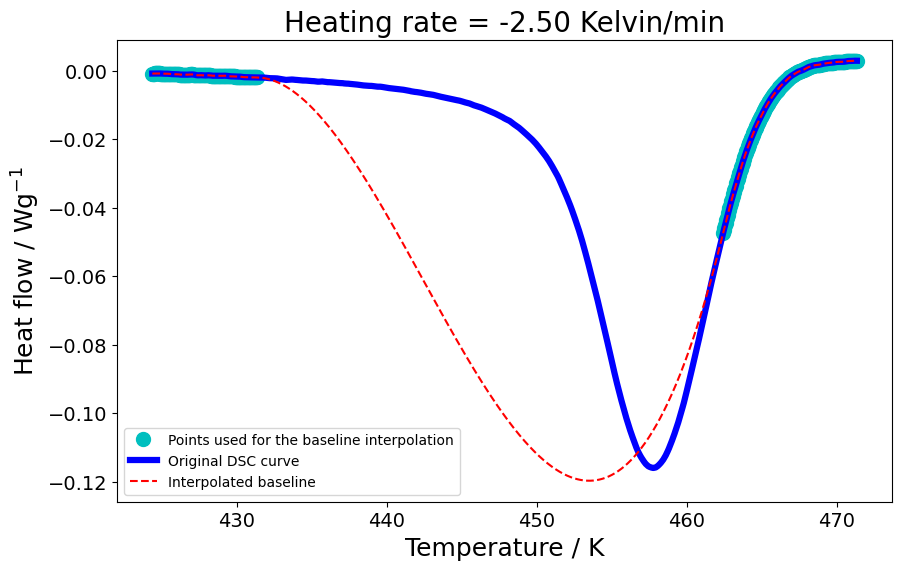

In [6]:
check_baseline()

# (2) Plot the "original" DSC curve(s) considering desired cuts at the beginning and end of the curve

In [ ]:
plot_original_dsc()

# (3) Plot the (baseline corrected/minimum set to zero) processed DSC curve(s) used for the calculation of the lamellar thickness distribution

In [ ]:
plot_dsc_basecorrect()

# (4) Plot time versus relative crystallization

In [ ]:
run2() 

# (5) Jeziorny analysis
The plot below is generated with the portion of data with crystallinity in the range of 20% - 80%

In [ ]:
run3() 